In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import os
import cv2
import copy
import time
import glob
import random
import datetime
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
from pycocotools.coco import COCO

import pprint
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms as T

#from dataset import COCO_INSTANCE_CATEGORY_NAMES
#from utils import  get_prediction, object_detection_api, instance_segmentation_api

In [2]:
from pycocotools.coco import COCO
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [3]:
root_img_path="D:/Dataset/Coco/val2014/"
valid_set=COCO('D:/Dataset/Coco/annotations/instances_val2014.json')

loading annotations into memory...
Done (t=5.31s)
creating index...
index created!


In [4]:
cats = valid_set.loadCats(valid_set.getCatIds()) 
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms))) 
nms = set([cat['supercategory'] for cat in cats]) 
print('COCO supercategories: \n{}'.format(' '.join(nms)))
from tqdm import tqdm


COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
outdoor food appliance accessory electronic animal vehicle sports kitchen furniture person indoor


In [176]:
def get_meta(coco):
    ids = list(coco.imgs.keys())
    for i, img_id in enumerate(ids):
        img_meta = coco.imgs[img_id]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # basic parameters of an image
        img_file_name = img_meta['file_name']
        w = img_meta['width']
        h = img_meta['height']
        # retrieve metadata for all persons in the current image
        anns = coco.loadAnns(ann_ids)

        yield [img_id, img_file_name, w, h, anns]

# iterate over images
keypoints={}
for img_id, img_fname, w, h, meta in get_meta(valid_set):
    # iterate over all annotations of an image
    keypoints[img_fname]=[]
    for m in meta:
        # m is a dictionary
        img=img
        keypoints[img_fname].append([COCO_INSTANCE_CATEGORY_NAMES[m['category_id']],m['bbox']])


[ 1] motorcycle          
[ 2] person              
[ 3] person              
[ 4] bicycle             


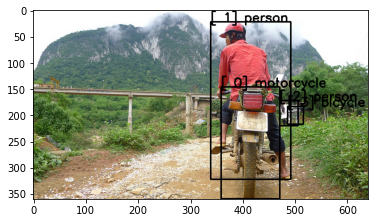

In [177]:
plt.figure()
img_fname=list(keypoints.keys())[0]
img = cv2.imread(os.path.join(root_img_path,img_fname))  # Read image with cv2
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

for n, (category,bbox)  in enumerate(keypoints[list(keypoints.keys())[0]]):
    print(f"[{n+1:2d}] {category:20s}")
    box_color = (0, 0, 0)
    cv2.rectangle(img,
                  (int(bbox[0]), int(bbox[1])),
                  (int(bbox[0]+int(bbox[2])),
                   (int(bbox[1])+int(bbox[3]))),
                  color=box_color, thickness=2)

    cv2.putText(img, f"[{n:2d}] "+category, (int(bbox[0]), int(bbox[1])),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color=box_color, thickness=2) 
    
plt.imshow(img)

## Top by Num Category

[ 1] motorcycle          
[ 2] person              
[ 3] person              
[ 4] bicycle             


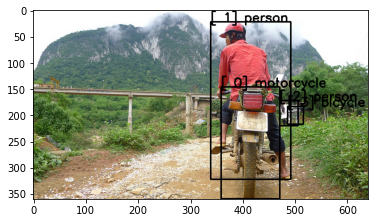

In [157]:
for n, (category,bbox) in enumerate(keypoints[list(keypoints.keys())[0]]):
    break

In [160]:
bbox

[359.17, 146.17, 112.45, 213.57]